In [ ]:
#### CAR PRICE PREDICTION ####

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score
import pickle


In [ ]:
from google.colab import files
uploaded = files.upload()

car = pd.read_csv('quikr_car.csv')
print("Initial Data:")
print(car.head())


Saving quikr_car.csv to quikr_car.csv
Initial Data:
                                     name   company  year          Price  \
0    Hyundai Santro Xing XO eRLX Euro III   Hyundai  2007         80,000   
1                 Mahindra Jeep CL550 MDI  Mahindra  2006       4,25,000   
2              Maruti Suzuki Alto 800 Vxi    Maruti  2018  Ask For Price   
3  Hyundai Grand i10 Magna 1.2 Kappa VTVT   Hyundai  2014       3,25,000   
4        Ford EcoSport Titanium 1.5L TDCi      Ford  2014       5,75,000   

   kms_driven fuel_type  
0  45,000 kms    Petrol  
1      40 kms    Diesel  
2  22,000 kms    Petrol  
3  28,000 kms    Petrol  
4  36,000 kms    Diesel  


In [ ]:
# Year column
car = car[car['year'].str.isnumeric()]
car['year'] = car['year'].astype(int)

# Price column
car = car[car['Price'] != 'Ask For Price']
car['Price'] = car['Price'].str.replace(',', '').astype(int)

# KMs driven
car['kms_driven'] = car['kms_driven'].str.split().str.get(0).str.replace(',', '')
car = car[car['kms_driven'].str.isnumeric()]
car['kms_driven'] = car['kms_driven'].astype(int)

# Remove missing fuel types
car = car[~car['fuel_type'].isna()]

# Keep only first 3 words of car name
car['name'] = car['name'].str.split().str.slice(0, 3).str.join(' ')

# Remove outlier prices
car = car[car['Price'] < 6000000]

# Reset index
car = car.reset_index(drop=True)

print("\n✅ Cleaned Data:")
print(car.head())



✅ Cleaned Data:
                     name   company  year   Price  kms_driven fuel_type
0     Hyundai Santro Xing   Hyundai  2007   80000       45000    Petrol
1     Mahindra Jeep CL550  Mahindra  2006  425000          40    Diesel
2       Hyundai Grand i10   Hyundai  2014  325000       28000    Petrol
3  Ford EcoSport Titanium      Ford  2014  575000       36000    Diesel
4               Ford Figo      Ford  2012  175000       41000    Diesel


/tmp/ipython-input-4-3273751165.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car['year'] = car['year'].astype(int)


In [ ]:
car.to_csv('Cleaned_Car_data.csv', index=False)


/tmp/ipython-input-6-741498100.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='fuel_type', y='Price', data=car, palette='pastel')


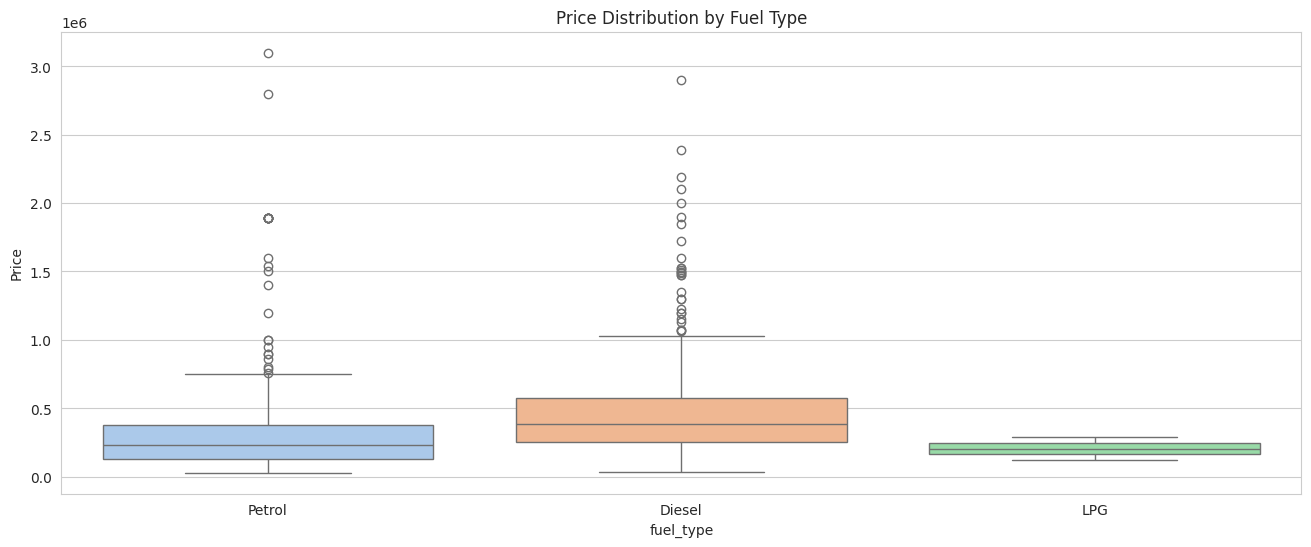

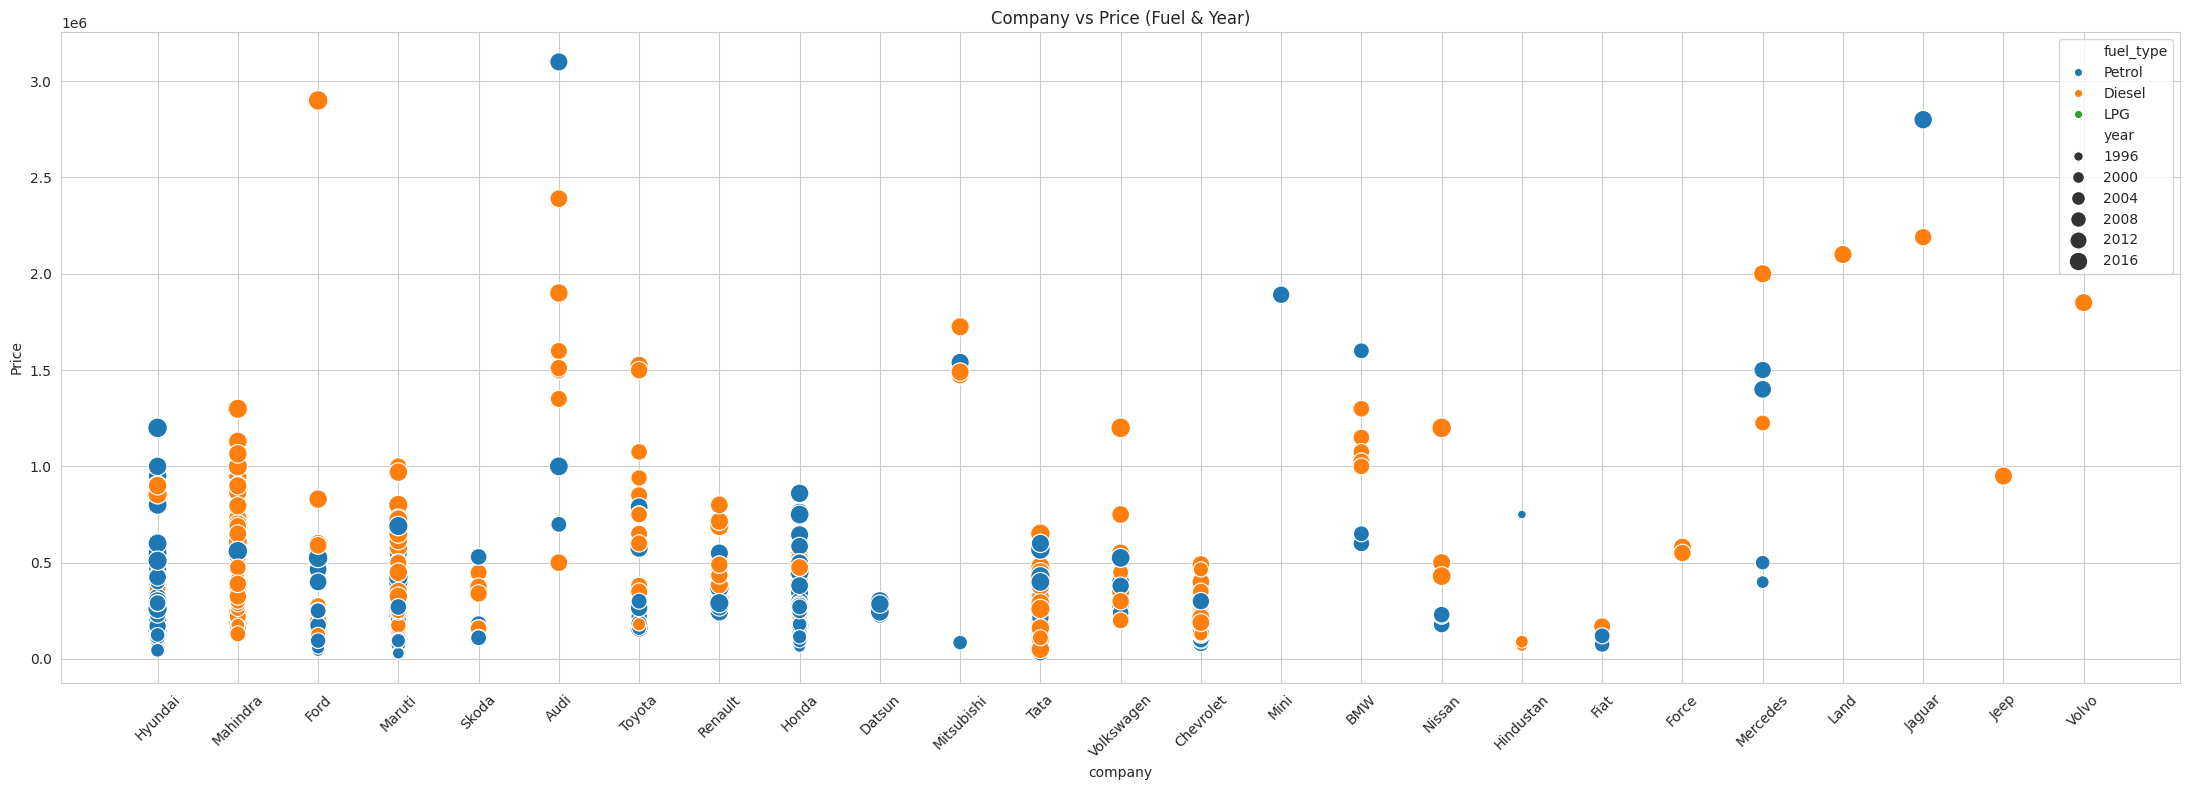

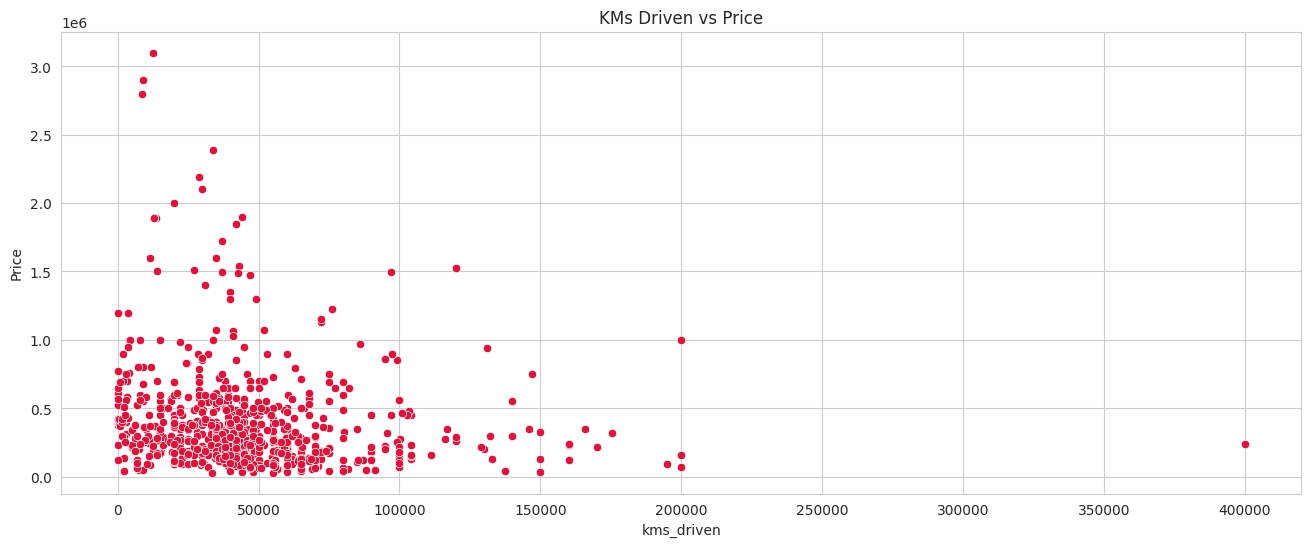

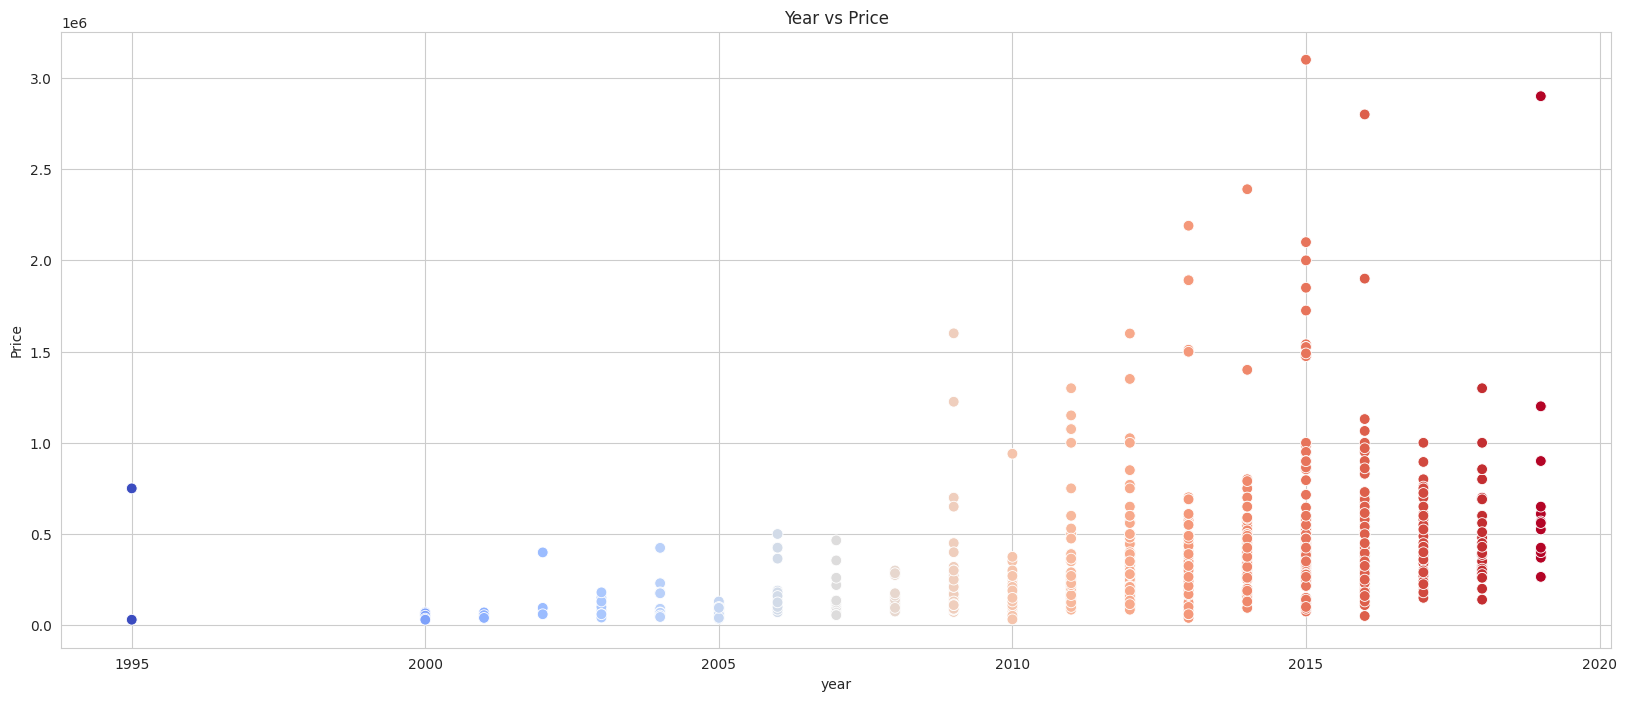

/tmp/ipython-input-6-741498100.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='company', y='Price', data=car, palette='Set2')


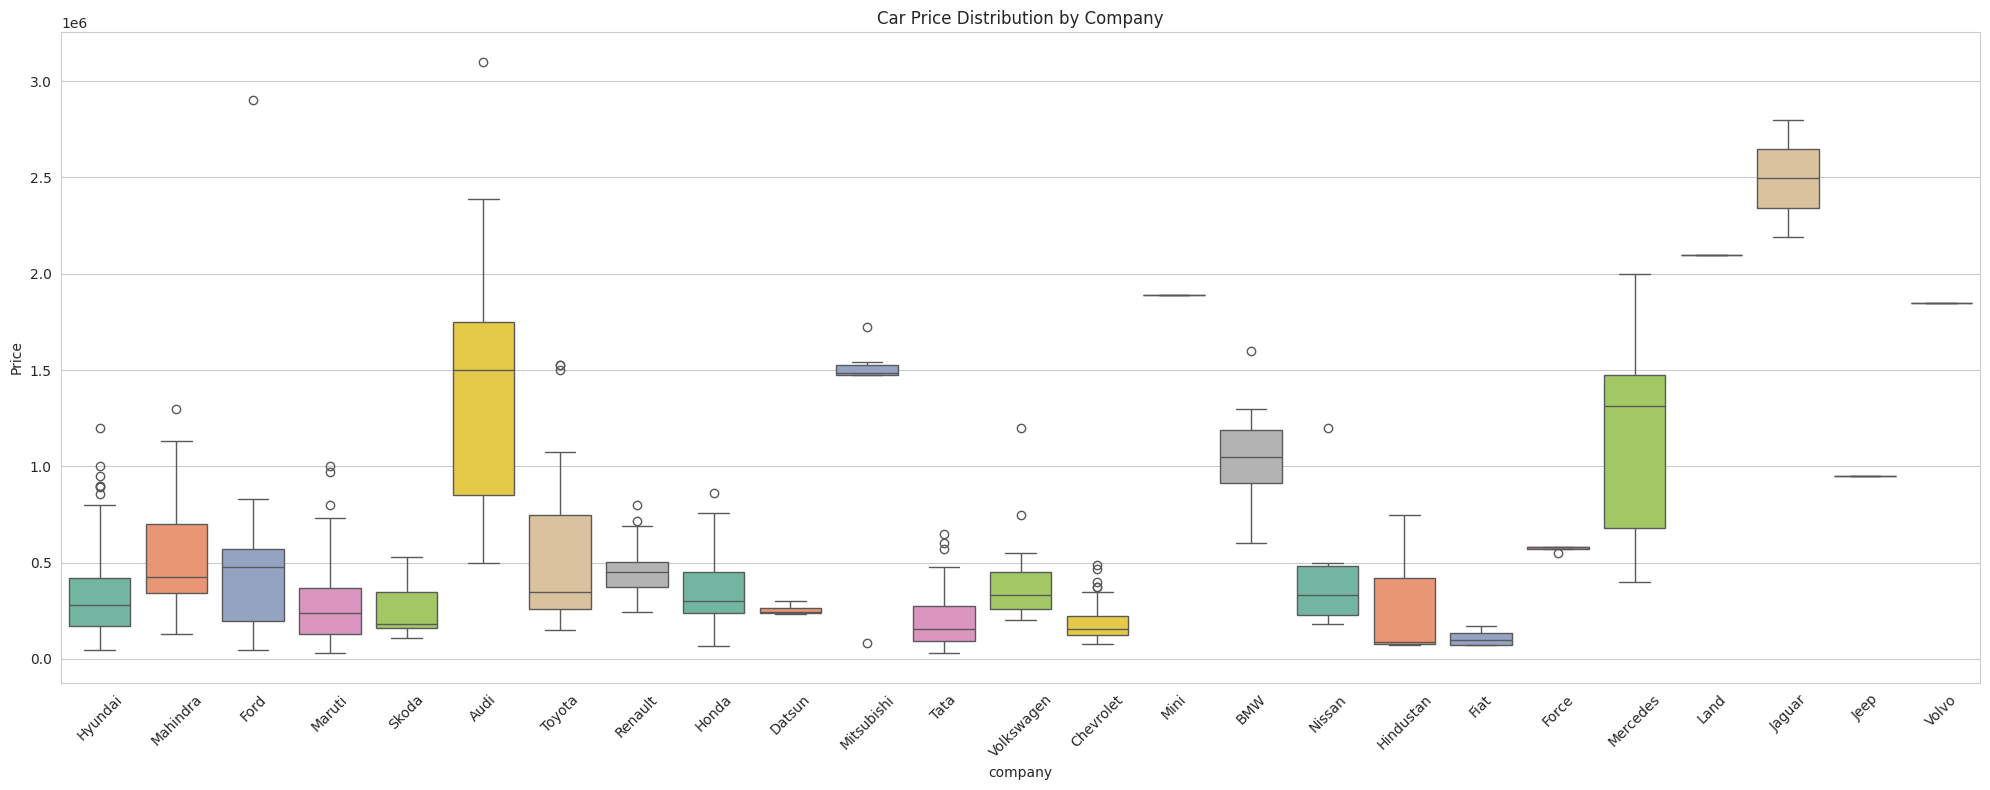

In [ ]:
# Global plot style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 6)

# 1. Fuel Type vs Price
sns.boxplot(x='fuel_type', y='Price', data=car, palette='pastel')
plt.title("Price Distribution by Fuel Type")
plt.show()

# 2. Company vs Price + Fuel Type & Year
plt.figure(figsize=(22, 8))
sns.scatterplot(x='company', y='Price', hue='fuel_type', size='year', data=car, sizes=(40, 200))
plt.title("Company vs Price (Fuel & Year)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 3. KMs Driven vs Price
sns.scatterplot(x='kms_driven', y='Price', data=car, color='crimson')
plt.title("KMs Driven vs Price")
plt.show()

# 4. Year vs Price
plt.figure(figsize=(20, 8))
sns.scatterplot(x='year', y='Price', hue='year', data=car, palette='coolwarm', s=60, legend=False)
plt.title("Year vs Price")
plt.show()

# 5. Company vs Price (Boxplot)
plt.figure(figsize=(20, 8))
sns.boxplot(x='company', y='Price', data=car, palette='Set2')
plt.title("Car Price Distribution by Company")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
X = car[['name', 'company', 'year', 'kms_driven', 'fuel_type']]
y = car['Price']

# OneHotEncode categorical features
ohe = OneHotEncoder()
ohe.fit(X[['name', 'company', 'fuel_type']])

column_trans = make_column_transformer(
    (OneHotEncoder(categories=ohe.categories_), ['name', 'company', 'fuel_type']),
    remainder='passthrough'
)

lr = LinearRegression()
pipe = make_pipeline(column_trans, lr)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print("\n📈 R2 Score:", r2_score(y_test, y_pred))



📈 R2 Score: 0.4849845121030534


In [ ]:
sample_input = pd.DataFrame(
    [['Maruti Suzuki Swift', 'Maruti', 2019, 100, 'Petrol']],
    columns=['name', 'company', 'year', 'kms_driven', 'fuel_type']
)

predicted_price = pipe.predict(sample_input)
print("\n💸 Predicted Price:", int(predicted_price[0]))



💸 Predicted Price: 418479


In [ ]:
pickle.dump(pipe, open('LinearRegressionModel.pkl', 'wb'))
print("\n✅ Model saved as 'LinearRegressionModel.pkl'")



✅ Model saved as 'LinearRegressionModel.pkl'
